In [1]:
import sys
import dill

import torch

# Monkey patch the method to enforce loading on CPU since we trained on CUDA
if not torch.cuda.is_available():
    base_load = torch.load
    torch.load = lambda f: base_load(f, map_location='cpu')

sys.path.append('../src')

In [2]:
import json
import numpy as np
import pandas as pd

df = pd.read_parquet('../preprocessed/vent-split-robust-cache/test-cols.parquet')

/usr/local/lib/python3.7/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
full_cats = pd.read_csv('../preprocessed/category_names.csv')[['category_name', 'name']]

top_cats = full_cats.category_name.unique()
top_cats.sort()
top_cats = {cat: i for i, cat in enumerate(top_cats)}

cat_for = {row['name']: top_cats[row.category_name] for i, row in full_cats.iterrows()}

emo_mapping = full_cats.name.unique()
emo_mapping.sort()
emo_index_mapping = {name: i for i, name in enumerate(emo_mapping)}
emo_name_mapping = {i: name for i, name in enumerate(emo_mapping)}
emo_mapping = {i: cat_for[name] for i, name in enumerate(emo_mapping)}

df['category_index'] = [emo_mapping[emotion] for emotion in df.emotion_index.tolist()]

labels_to_ignore = set() # {'Meh', 'Thoughtful', 'Spacey'}
valid_suffix = 'Valid' if labels_to_ignore else ''
invalid_label_indices = {emo_index_mapping[label] for label in labels_to_ignore}
valid_label_indices = [index for index in range(len(emo_index_mapping)) if index not in invalid_label_indices]
valid_emos = [name for name in sorted(emo_index_mapping.keys()) if name not in labels_to_ignore]
valid_index_mapping = {name: i for i, name in enumerate(valid_emos)}

# Data and model preparation

In [4]:
vent_bert_lstm_hash = '66c65a184361c8a5b33890783c9ed7a0'
vent_tfidf_logreg_hash = '1bc7b487f61026fdfefc8afb524589cf'

experiment_hash = vent_bert_lstm_hash
is_bert = experiment_hash == vent_bert_lstm_hash

try:
    config = json.load(open(f'../output/Vent/replica-full/{experiment_hash}.json'))
except FileNotFoundError:
    config = json.load(open(f'../output/Vent/replica-fractions-with-test/{experiment_hash}.json'))
thresholds = np.asarray(config['results']['thresholds'][1])

try:
    cats, extractor, model = dill.load(open(f'../models/Vent/{experiment_hash}.pkl', 'rb'))
except FileNotFoundError:
    cats, extractor, model = dill.load(open(f'../models/Vent/fractions-with-test/{experiment_hash}.pkl', 'rb'))

In [5]:
from utils.generators import SizedCallableWrapper, SizedBatchWrapper

NUM_LABELS = len(thresholds)
NUM_CATEGORIES = len(top_cats)
NUM_SAMPLES = 1000000
BATCH_SIZE = 128
inputs = df.text.tolist()[:NUM_SAMPLES]
labels = df.emotion_index.tolist()[:NUM_SAMPLES]

input_batches = SizedBatchWrapper(inputs, batch_size=BATCH_SIZE)
input_vectors = SizedCallableWrapper(input_batches, extractor)
output = model.predict(input_vectors)
output_labels = 1 * (output > thresholds) 

Predict:   0%|          | 0/7614 [00:00<?, ?it/s]/usr/local/lib/python3.7/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/usr/local/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Predict: 100%|██████████| 7614/7614 [32:39<00:00,  3.88it/s]


# Category-level classification report

In [6]:
from utils.evaluate import classification_report

dataset_samples = len(output)
category_output = np.zeros((len(output), NUM_CATEGORIES))

for instance_index, label_index in zip(*np.nonzero(output_labels)):
    if label_index in invalid_label_indices:
        continue
    category_index = emo_mapping[label_index]
    category_output[instance_index, category_index] = 1

category_truth = np.zeros((len(output), NUM_CATEGORIES))
category_truth[np.arange(dataset_samples), df.category_index.tolist()[:dataset_samples]] = 1

report = classification_report(category_truth, category_output, sorted(list(top_cats)))
total_support = 0
total_prec = 0
total_rec = 0
for label, stats in report['labels'].items():
    p = stats['precision']
    r = stats['recall']
    f = stats['f1']
    s = stats['support']
    print('{}\tPrecision: {:.3f}\tRecall: {:.3f}\tF1-score: {:.3f}\tSupport: {:.0f}'.format(label, p, r, f, s))
    total_rec += r * s
    total_prec += p * s
    total_support += s
    
total_prec /= total_support
total_rec /= total_support
print('')
print('Mean macro F1-score: {:.2f}'.format(report['macro_f1']))
print('Mean micro F1-score: {:.2f}'.format(report['micro_f1']))
print('Mean micro Precision: {:.2f}'.format(total_prec))
print('Mean micro Recall: {:.2f}'.format(total_rec))

Affection	Precision: 0.528	Recall: 0.490	F1-score: 0.508	Support: 79211
Anger	Precision: 0.435	Recall: 0.387	F1-score: 0.410	Support: 84495
Creativity	Precision: 0.265	Recall: 0.380	F1-score: 0.312	Support: 115576
Fear	Precision: 0.408	Recall: 0.333	F1-score: 0.367	Support: 85508
Feelings	Precision: 0.360	Recall: 0.432	F1-score: 0.393	Support: 168092
Happiness	Precision: 0.426	Recall: 0.461	F1-score: 0.443	Support: 128036
Positivity	Precision: 0.289	Recall: 0.290	F1-score: 0.290	Support: 46518
Sadness	Precision: 0.509	Recall: 0.560	F1-score: 0.533	Support: 209257
Surprise	Precision: 0.344	Recall: 0.343	F1-score: 0.344	Support: 57886

Mean macro F1-score: 0.40
Mean micro F1-score: 0.42
Mean micro Precision: 0.41
Mean micro Recall: 0.44


# Confusion matrix & Hierarchical Clustering of label activations

In [7]:
label_confusion_matrix = np.zeros((NUM_LABELS, NUM_LABELS))

for instance_index, label_index in zip(*np.nonzero(output_labels)):
    if label_index in invalid_label_indices:
        continue
    actual_label = labels[instance_index]
    label_confusion_matrix[actual_label, label_index] += 1

for i, row in enumerate(label_confusion_matrix):
    row_count = row.sum()
    if row_count > 0:
        label_confusion_matrix[i] /= row.sum()

label_confusion_matrix = np.asarray([row[valid_label_indices] for i, row in enumerate(label_confusion_matrix)])[valid_label_indices]

In [8]:
category_colors = {
    'Affection': '#DDA0DD', 'Anger': '#FF0000', 'Creativity': '#7DA8D6', 'Fear': '#800180', 'Feelings': '#808080', 'Happiness': '#EFAF00', 'Positivity': '#EFAFCB', 'Sadness': '#4682B4', 'Surprise': '#00AF02'
}

top_cats_inverse = {i: cat for cat, i in top_cats.items()}
link_color_mapping = {valid_index_mapping[emo_name_mapping[emo]]: category_colors[top_cats_inverse[cat]] 
                      for emo, cat in emo_mapping.items() 
                      if emo not in invalid_label_indices}

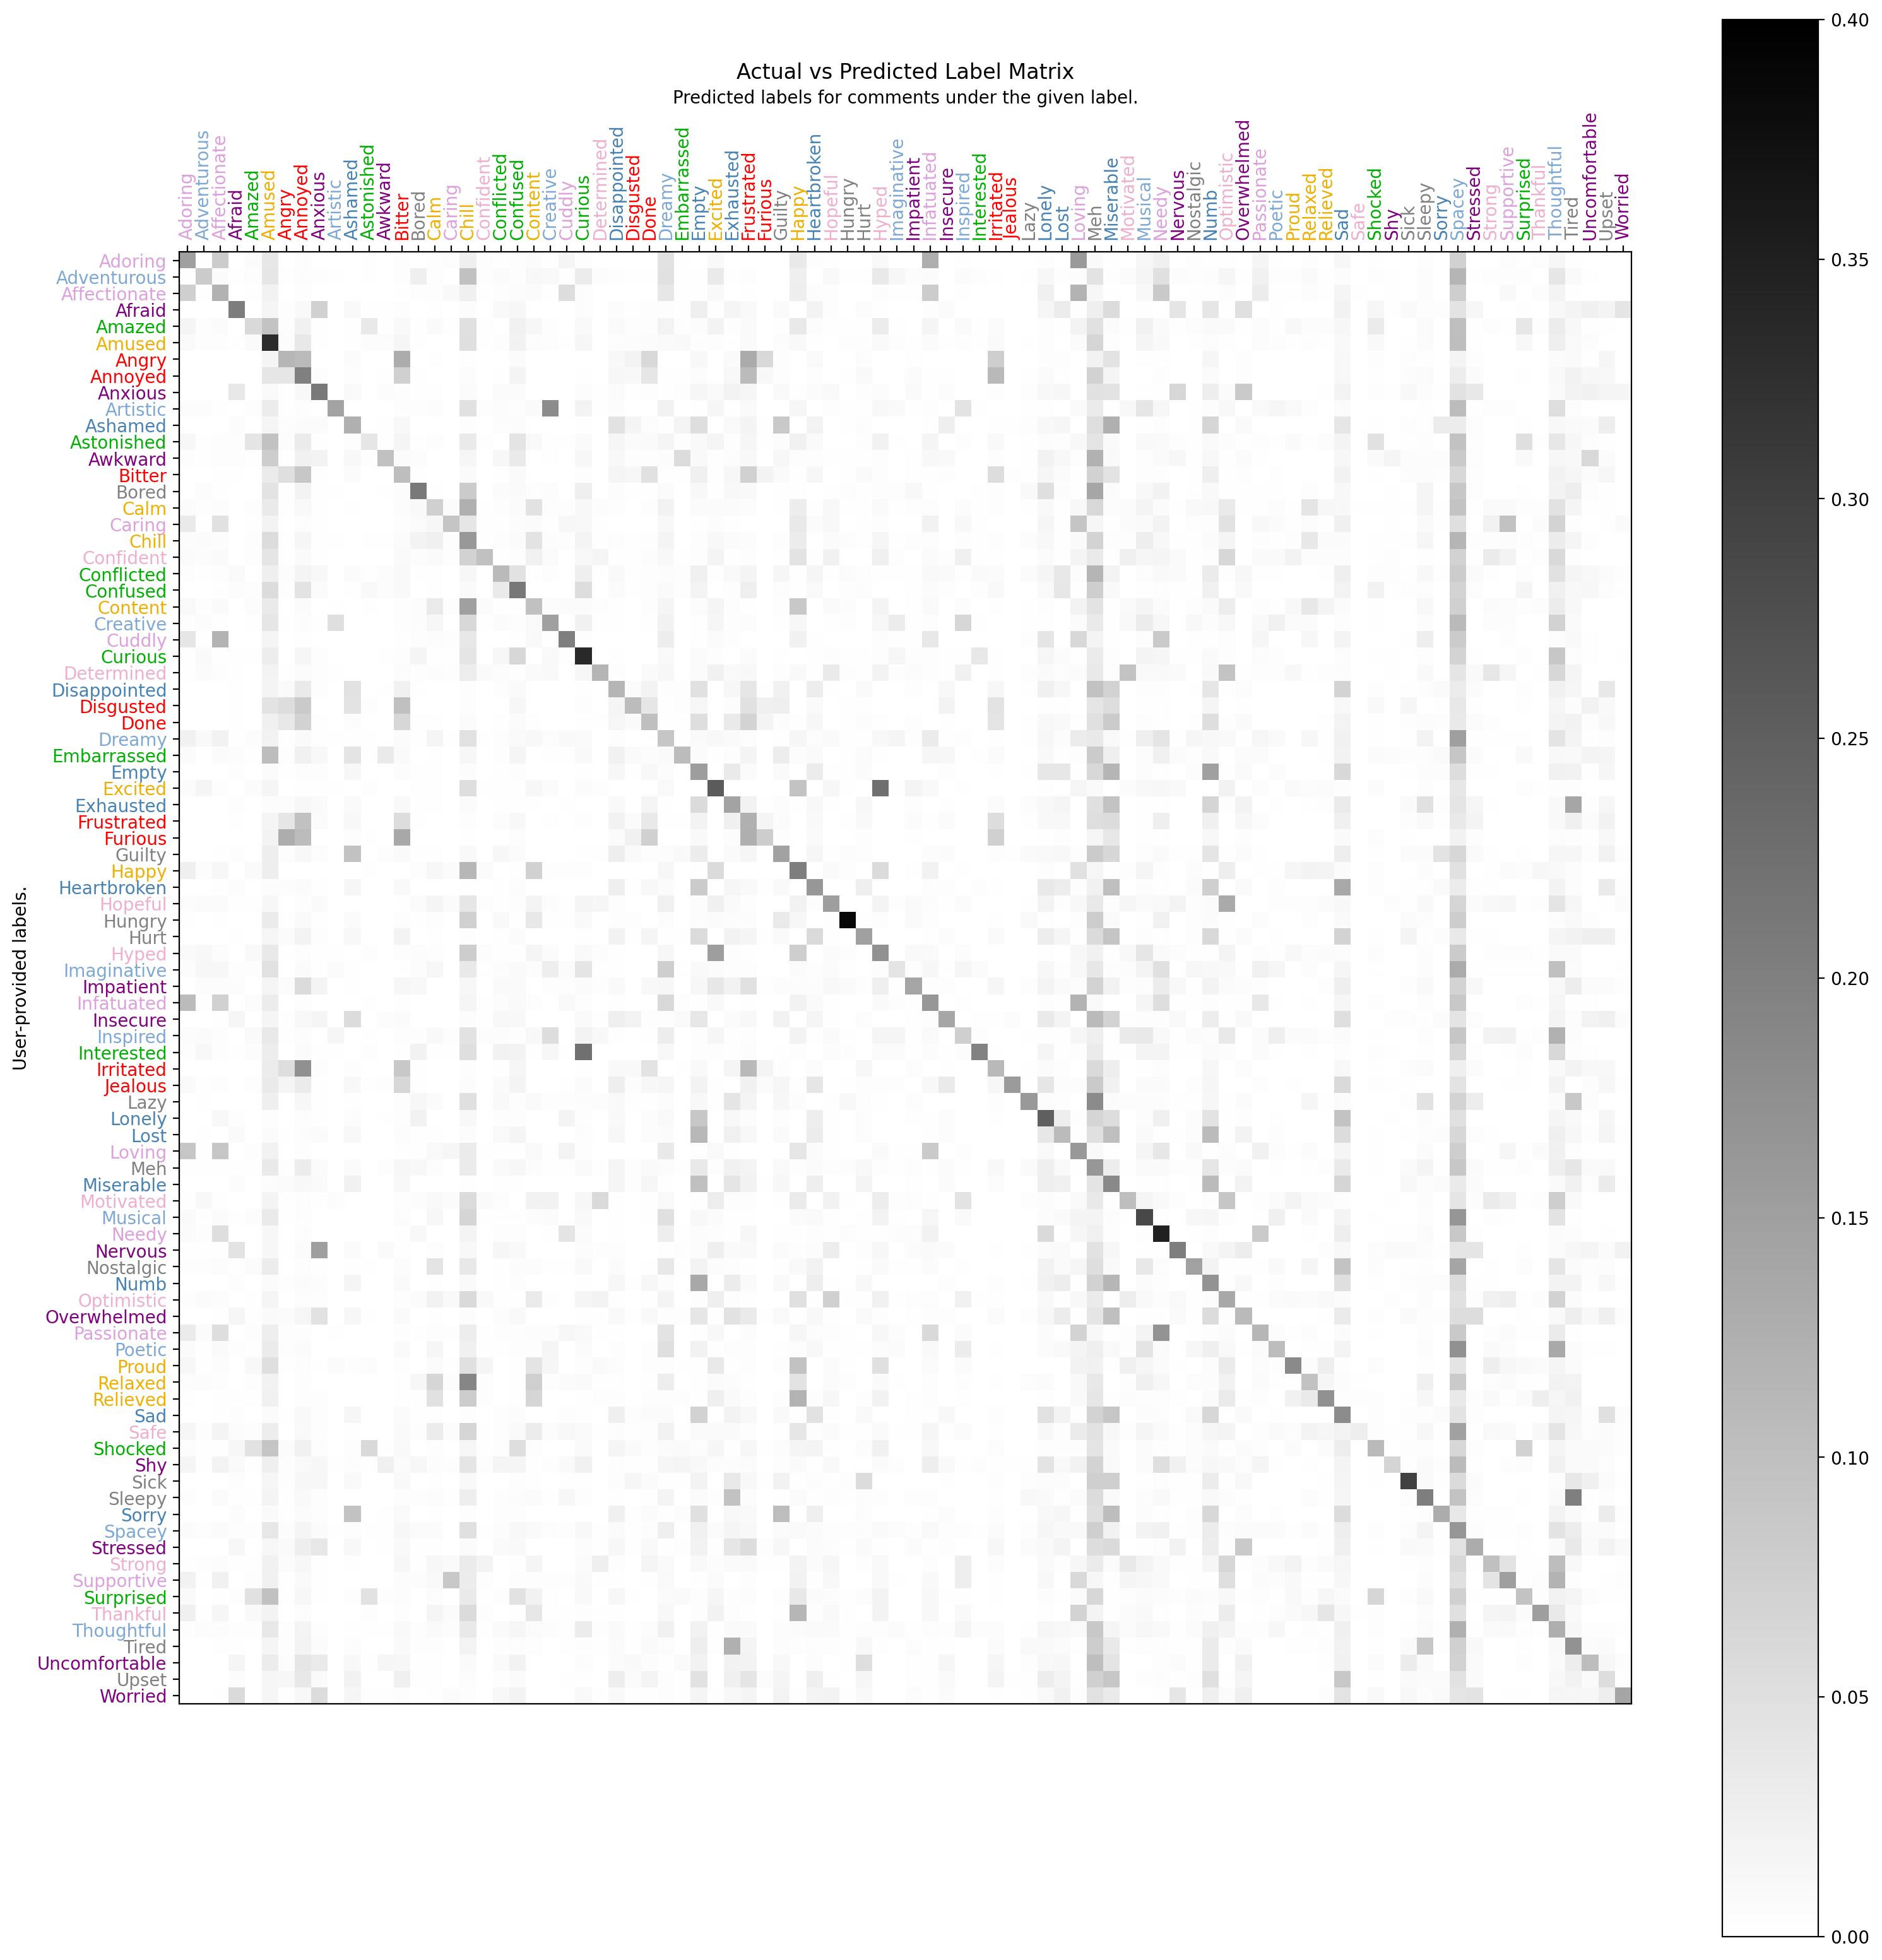

In [9]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(16, 16), dpi=200)
abs_max = round(label_confusion_matrix.max() * 20) / 20
plt.matshow(label_confusion_matrix, fignum=0, cmap='gist_yarg', vmin=0, vmax=abs_max)
plt.colorbar()
plt.title('Actual vs Predicted Label Matrix')
plt.xlabel('Predicted labels for comments under the given label.')
plt.ylabel('User-provided labels.')
plt.yticks(np.arange(NUM_LABELS - len(labels_to_ignore)), labels=valid_emos)
plt.xticks(np.arange(NUM_LABELS - len(labels_to_ignore)), labels=valid_emos, rotation='vertical')
fig.axes[0].xaxis.tick_top()
fig.axes[0].xaxis.set_label_position('top') 

for tick in list(fig.axes[0].xaxis.get_ticklabels()) + list(fig.axes[0].yaxis.get_ticklabels()):
    label = tick.get_text()
    emotion_index = valid_index_mapping[label]
    color = link_color_mapping[emotion_index]
    tick.set_color(color)

plt.tight_layout()
plt.savefig(f'../output/EmotionConfusionMatrixAlphabetical{valid_suffix}.pdf')
plt.show()

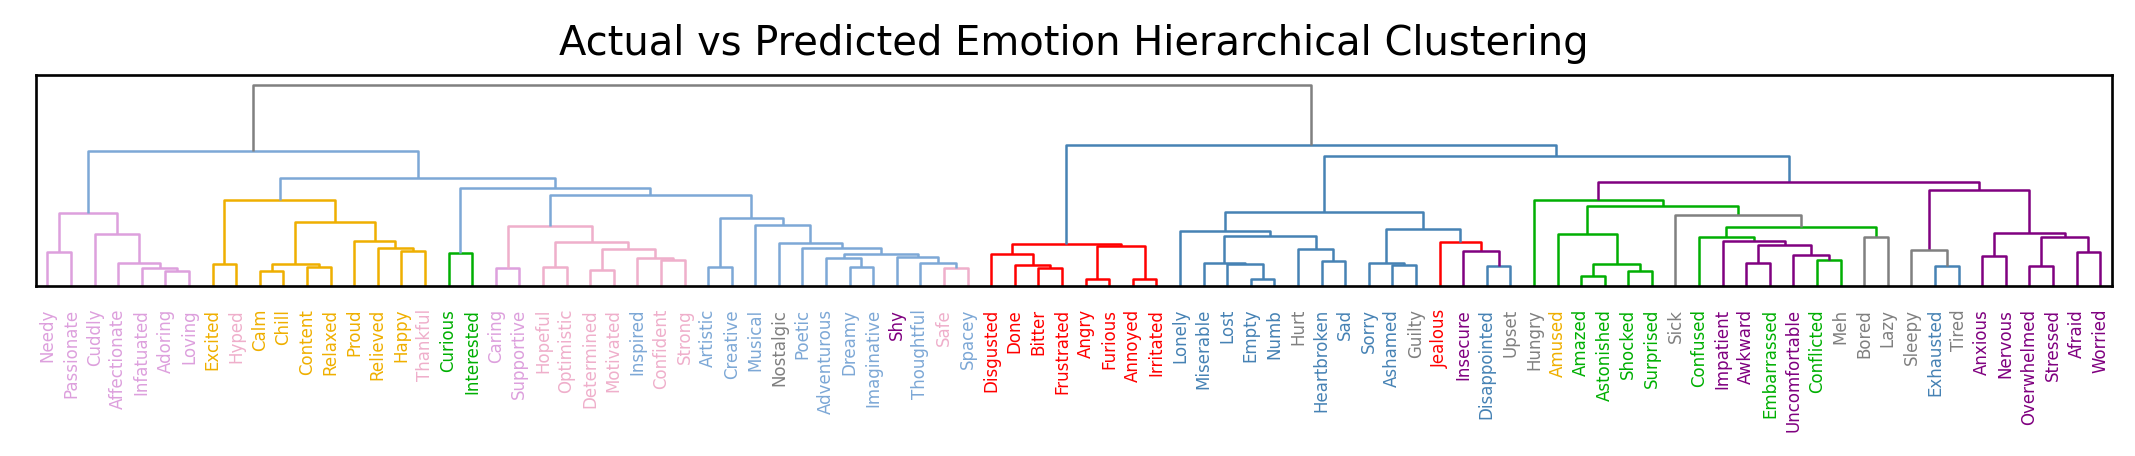

In [10]:
from collections import defaultdict
from scipy.cluster.hierarchy import dendrogram, set_link_color_palette
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)
    
    # Assign the colors of every leaf
    node_colors = defaultdict(lambda: defaultdict(int))
    for node, color in link_color_mapping.items():
        node_colors[node][color] += 1
    
    # Compute the color in every node
    for node_index, pair in enumerate(model.children_, n_samples):
        for pair_index in pair:
            colors = node_colors[pair_index]
            for color, count in colors.items():
                node_colors[node_index][color] += count
    
    # Plot the corresponding dendrogram
    def func(index):
        color_map = node_colors[index].items()
        color = sorted(list(color_map), key=lambda x: -x[1])[0][0]
        return color
    dendrogram(linkage_matrix, labels=valid_emos, link_color_func=func, **kwargs)

dend = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
dend = dend.fit(2 / (label_confusion_matrix + 1.0) - 1)

plt.figure(figsize=(9, 2), dpi=240)
plt.yticks([])
plt.title('Actual vs Predicted Emotion Hierarchical Clustering')

plt.rcParams["lines.linewidth"] = 0.75
plot_dendrogram(dend)
plt.rcParams["lines.linewidth"] = 2

ax = plt.gca()
x_labels = ax.get_xmajorticklabels()

for i, x in enumerate(x_labels):
    emotion_index = valid_index_mapping[x.get_text()]
    color = link_color_mapping[emotion_index]
    x.set_color(color)

plt.tight_layout()
plt.savefig(f'../output/EmotionDendrogram{valid_suffix}.pdf')
plt.show()

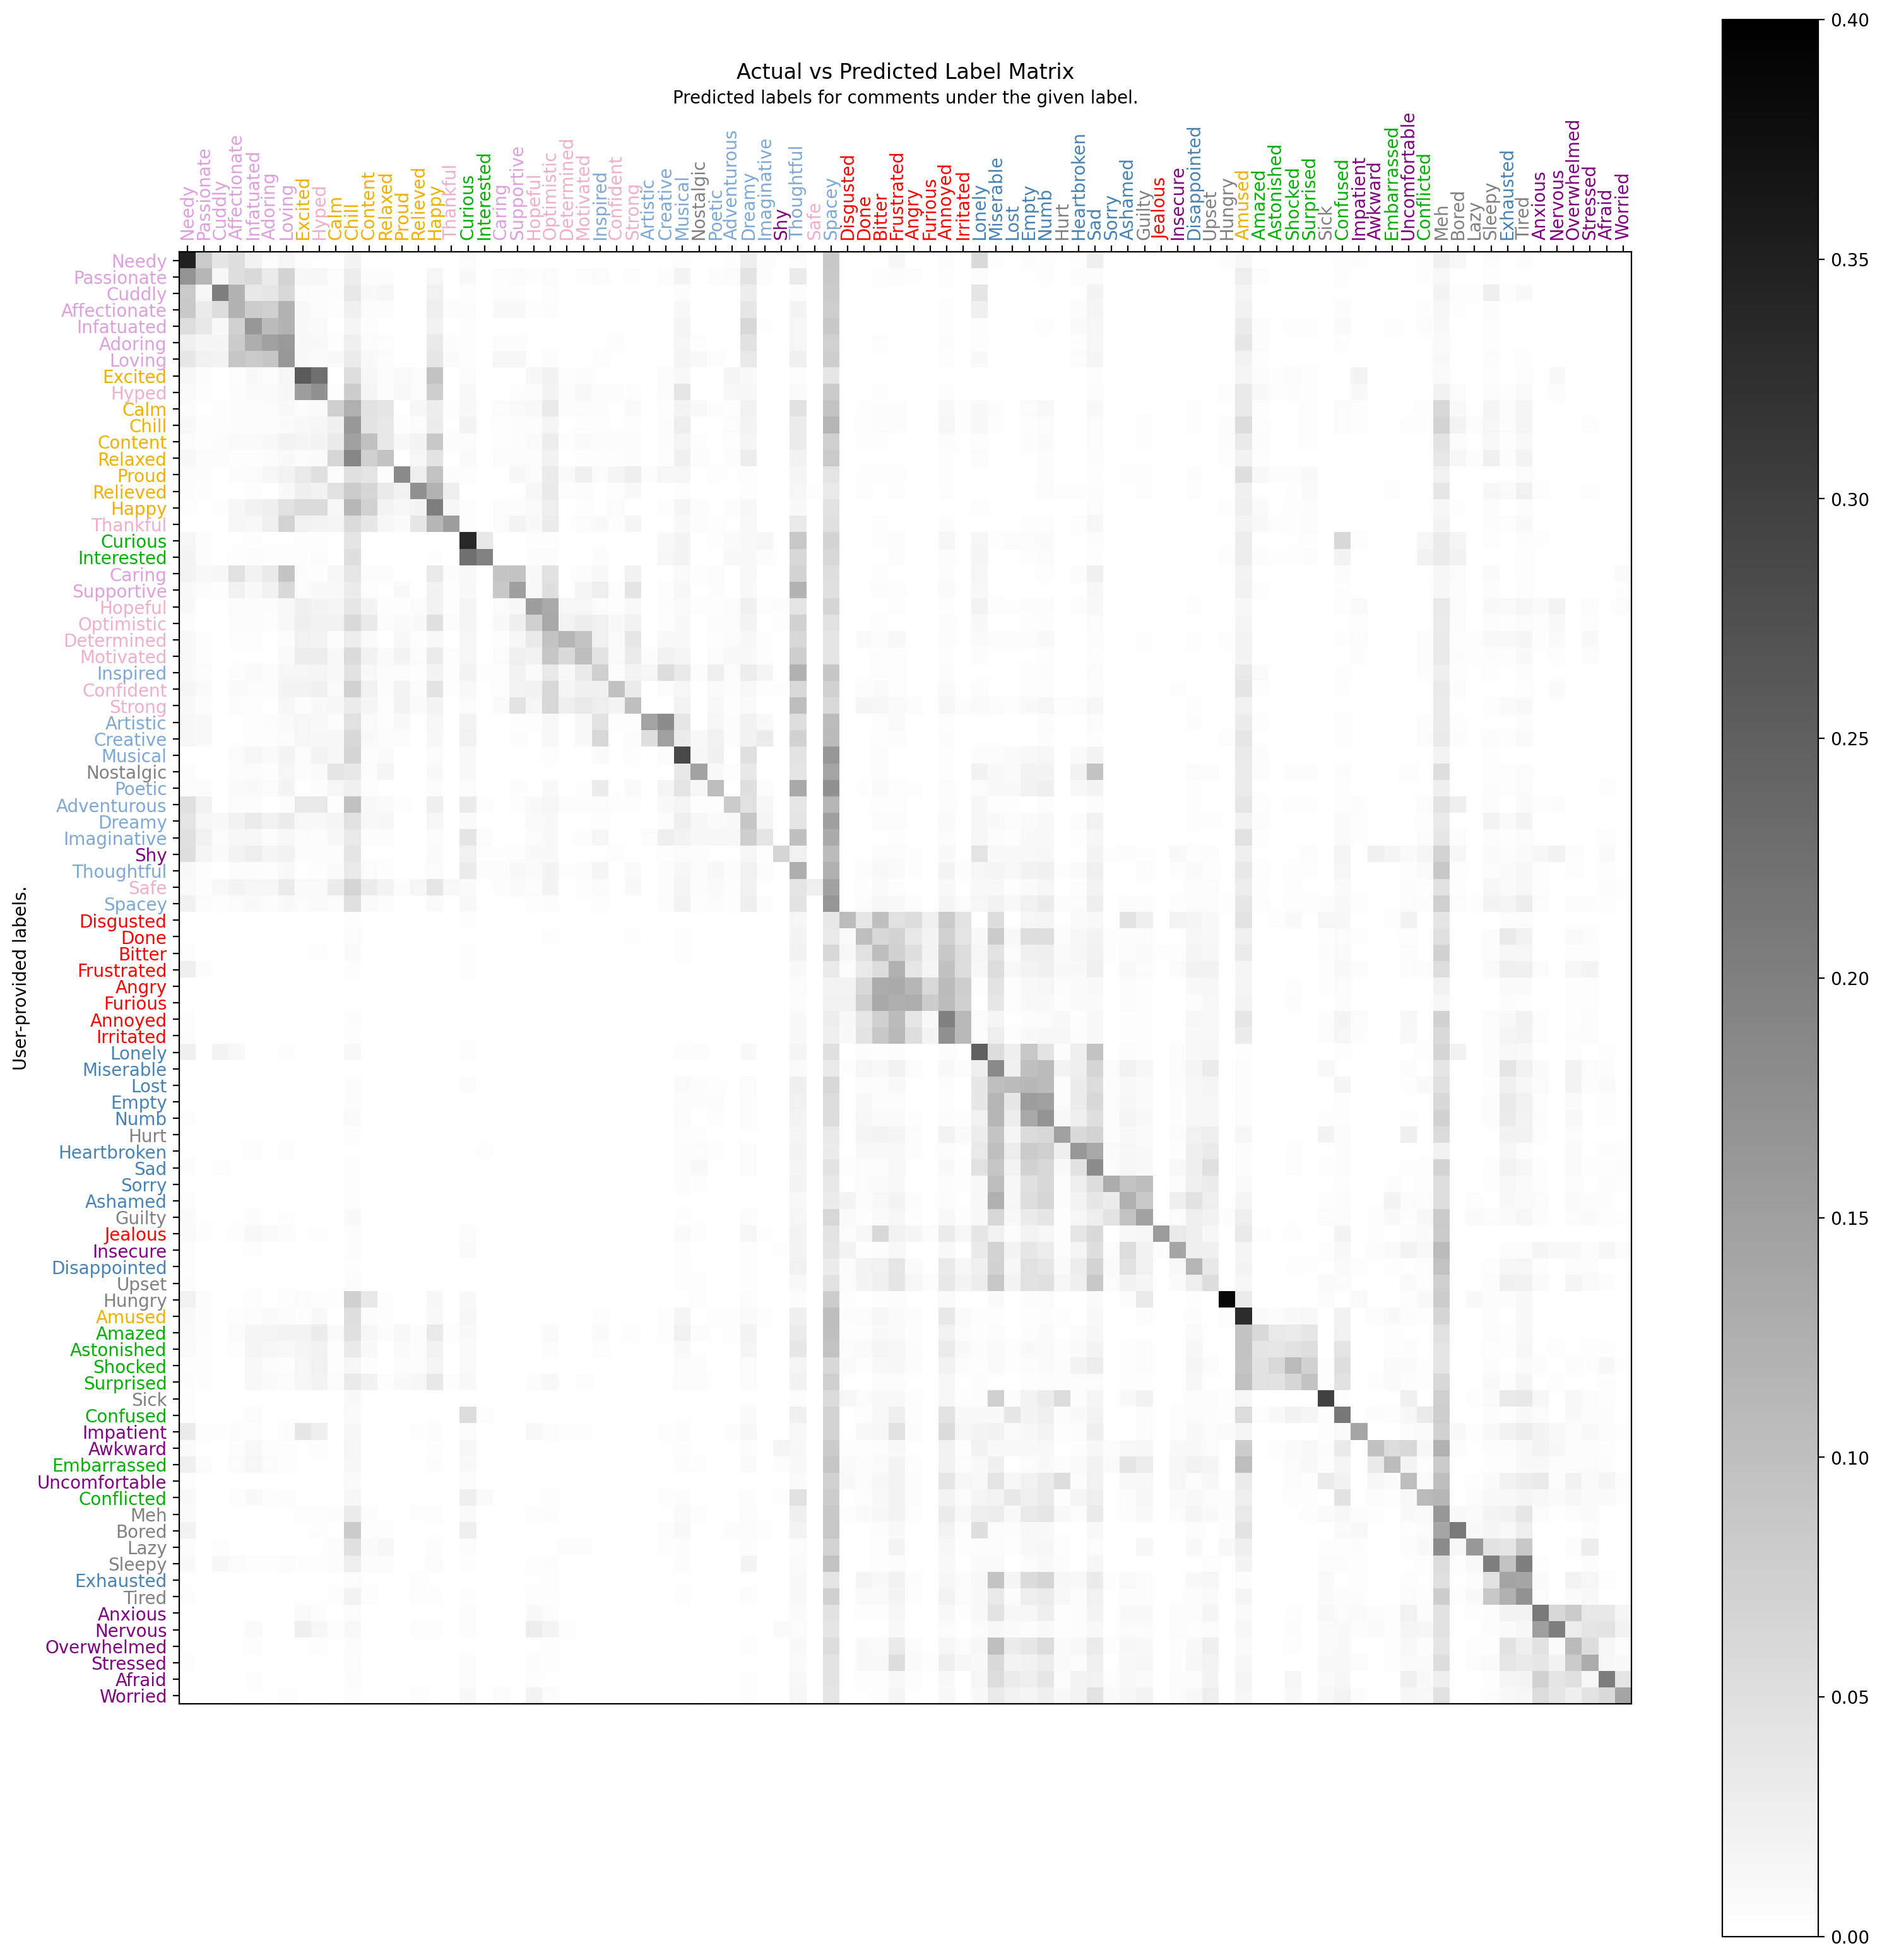

In [11]:
from matplotlib import pyplot as plt

dendrogram_order = [label.get_text() for label in x_labels]
dendrogram_indices = [valid_index_mapping[label] for label in dendrogram_order]

label_confusion_matrix_dend = np.asarray([row[dendrogram_indices] for row in label_confusion_matrix])
label_confusion_matrix_dend = label_confusion_matrix_dend[dendrogram_indices]

fig = plt.figure(figsize=(16, 16), dpi=200)
abs_max = round(label_confusion_matrix_dend.max() * 20) / 20
plt.matshow(label_confusion_matrix_dend, fignum=0, cmap='gist_yarg', vmin=0, vmax=abs_max)
plt.colorbar()
plt.title('Actual vs Predicted Label Matrix')
plt.xlabel('Predicted labels for comments under the given label.')
plt.ylabel('User-provided labels.')
plt.yticks(np.arange(NUM_LABELS - len(labels_to_ignore)), labels=dendrogram_order)
plt.xticks(np.arange(NUM_LABELS - len(labels_to_ignore)), labels=dendrogram_order, rotation='vertical')
fig.axes[0].xaxis.tick_top()
fig.axes[0].xaxis.set_label_position('top')

for tick in list(fig.axes[0].xaxis.get_ticklabels()) + list(fig.axes[0].yaxis.get_ticklabels()):
    label = tick.get_text()
    emotion_index = valid_index_mapping[label]
    color = link_color_mapping[emotion_index]
    tick.set_color(color)

plt.tight_layout()
plt.savefig(f'../output/EmotionConfusionMatrixDendrogram{valid_suffix}.pdf')
plt.show()

# Category confusion matrix

In [12]:
cat_confusion_matrix = np.zeros((NUM_CATEGORIES, NUM_CATEGORIES))
categories_sorted = sorted(list(category_colors))

category_index_colors = {i: category_colors[n] for i, n in enumerate(categories_sorted)}
category_index_mapping = {n: i for i, n in enumerate(categories_sorted)}

seen_sets = defaultdict(set)
for instance_index, label_index in zip(*np.nonzero(output_labels)):
    if label_index in invalid_label_indices:
        continue
    actual_label = labels[instance_index]
    actual_cat = emo_mapping[actual_label]
    cat_index = emo_mapping[label_index]
    
    if cat_index not in seen_sets[instance_index]:
        cat_confusion_matrix[actual_cat, cat_index] += 1
        seen_sets[instance_index].add(cat_index)

for i, row in enumerate(cat_confusion_matrix):
    row_count = row.sum()
    if row_count > 0:
        cat_confusion_matrix[i] /= row.sum()

cat_confusion_matrix

array([[0.45320364, 0.01649988, 0.19248689, 0.0164882 , 0.05984563,
        0.11594288, 0.03888506, 0.07746652, 0.02918131],
       [0.01881601, 0.38315809, 0.0768213 , 0.05857902, 0.17197855,
        0.06234925, 0.0096012 , 0.18124019, 0.03745638],
       [0.07337172, 0.0349755 , 0.35482541, 0.03255754, 0.14141422,
        0.14458426, 0.04782545, 0.11353087, 0.05691504],
       [0.01955767, 0.06438329, 0.09043091, 0.31237372, 0.17751252,
        0.05085434, 0.0243565 , 0.20609681, 0.05443424],
       [0.02336954, 0.05580211, 0.12953801, 0.05307385, 0.3775087 ,
        0.083329  , 0.01570441, 0.22912747, 0.0325469 ],
       [0.05463428, 0.03072328, 0.17076525, 0.02278637, 0.10550784,
        0.42304855, 0.10382447, 0.03966304, 0.04904693],
       [0.07123491, 0.02048481, 0.19617215, 0.03584841, 0.0776816 ,
        0.24208222, 0.27134336, 0.05081035, 0.03434218],
       [0.01935099, 0.05182313, 0.09391455, 0.05459867, 0.21557158,
        0.02610827, 0.00924317, 0.5062774 , 0.02311224],


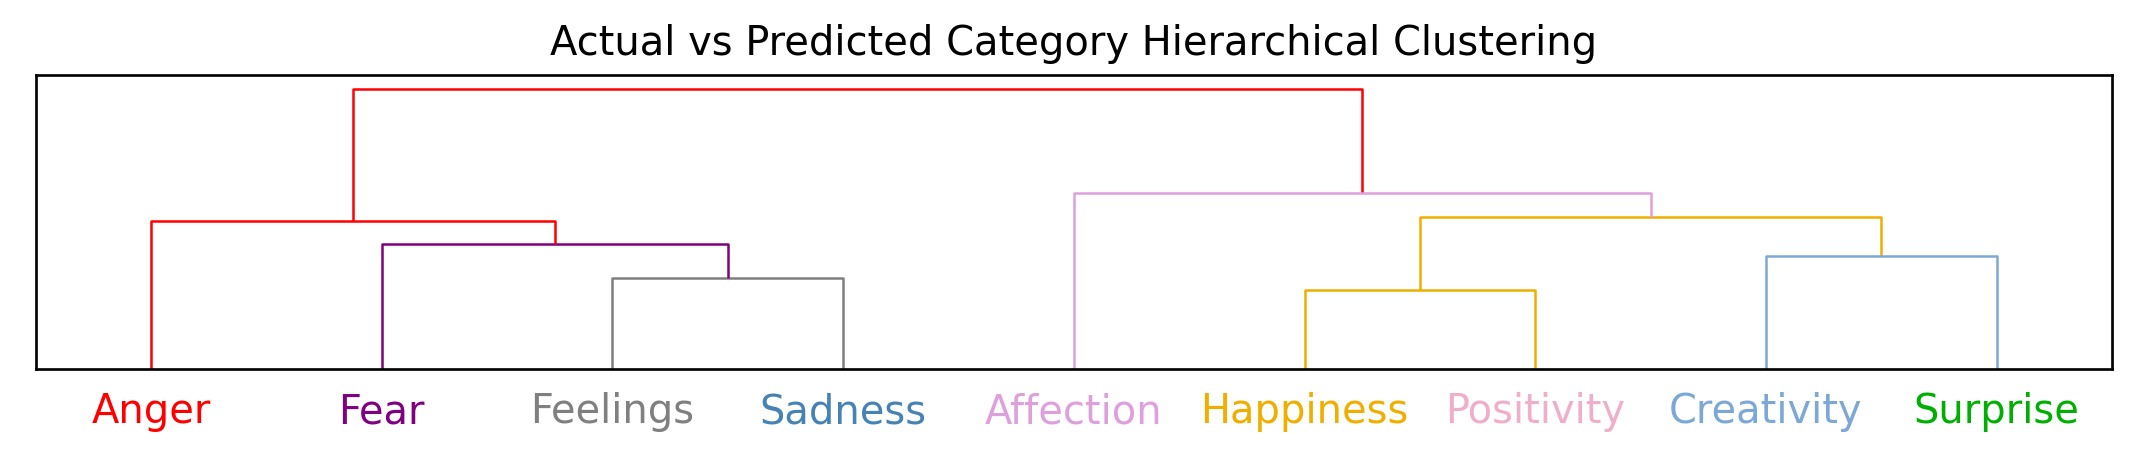

In [13]:
from collections import defaultdict
from scipy.cluster.hierarchy import dendrogram, set_link_color_palette
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)
    
    # Assign the colors of every leaf
    node_colors = defaultdict(lambda: defaultdict(int))
    for node, color in category_index_colors.items():
        node_colors[node][color] += 1
    
    # Compute the color in every node
    for node_index, pair in enumerate(model.children_, n_samples):
        for pair_index in pair:
            colors = node_colors[pair_index]
            for color, count in colors.items():
                node_colors[node_index][color] += count
    
    # Plot the corresponding dendrogram
    def func(index):
        color_map = node_colors[index].items()
        color = sorted(list(color_map), key=lambda x: -x[1])[0][0]
        return color
    dendrogram(linkage_matrix, labels=categories_sorted, link_color_func=func, **kwargs)

dend = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
dend = dend.fit(2 / (cat_confusion_matrix + 1.0) - 1)

plt.figure(figsize=(9, 2), dpi=240)
plt.yticks([])
plt.title('Actual vs Predicted Category Hierarchical Clustering')

plt.rcParams["lines.linewidth"] = 0.75
plot_dendrogram(dend)
plt.rcParams["lines.linewidth"] = 2

ax = plt.gca()
x_labels = ax.get_xmajorticklabels()

for i, x in enumerate(x_labels):
    color = category_colors[x.get_text()]
    x.set_color(color)

plt.tight_layout()
plt.savefig(f'../output/EmotionCategoryDendrogram{valid_suffix}.pdf')
plt.show()

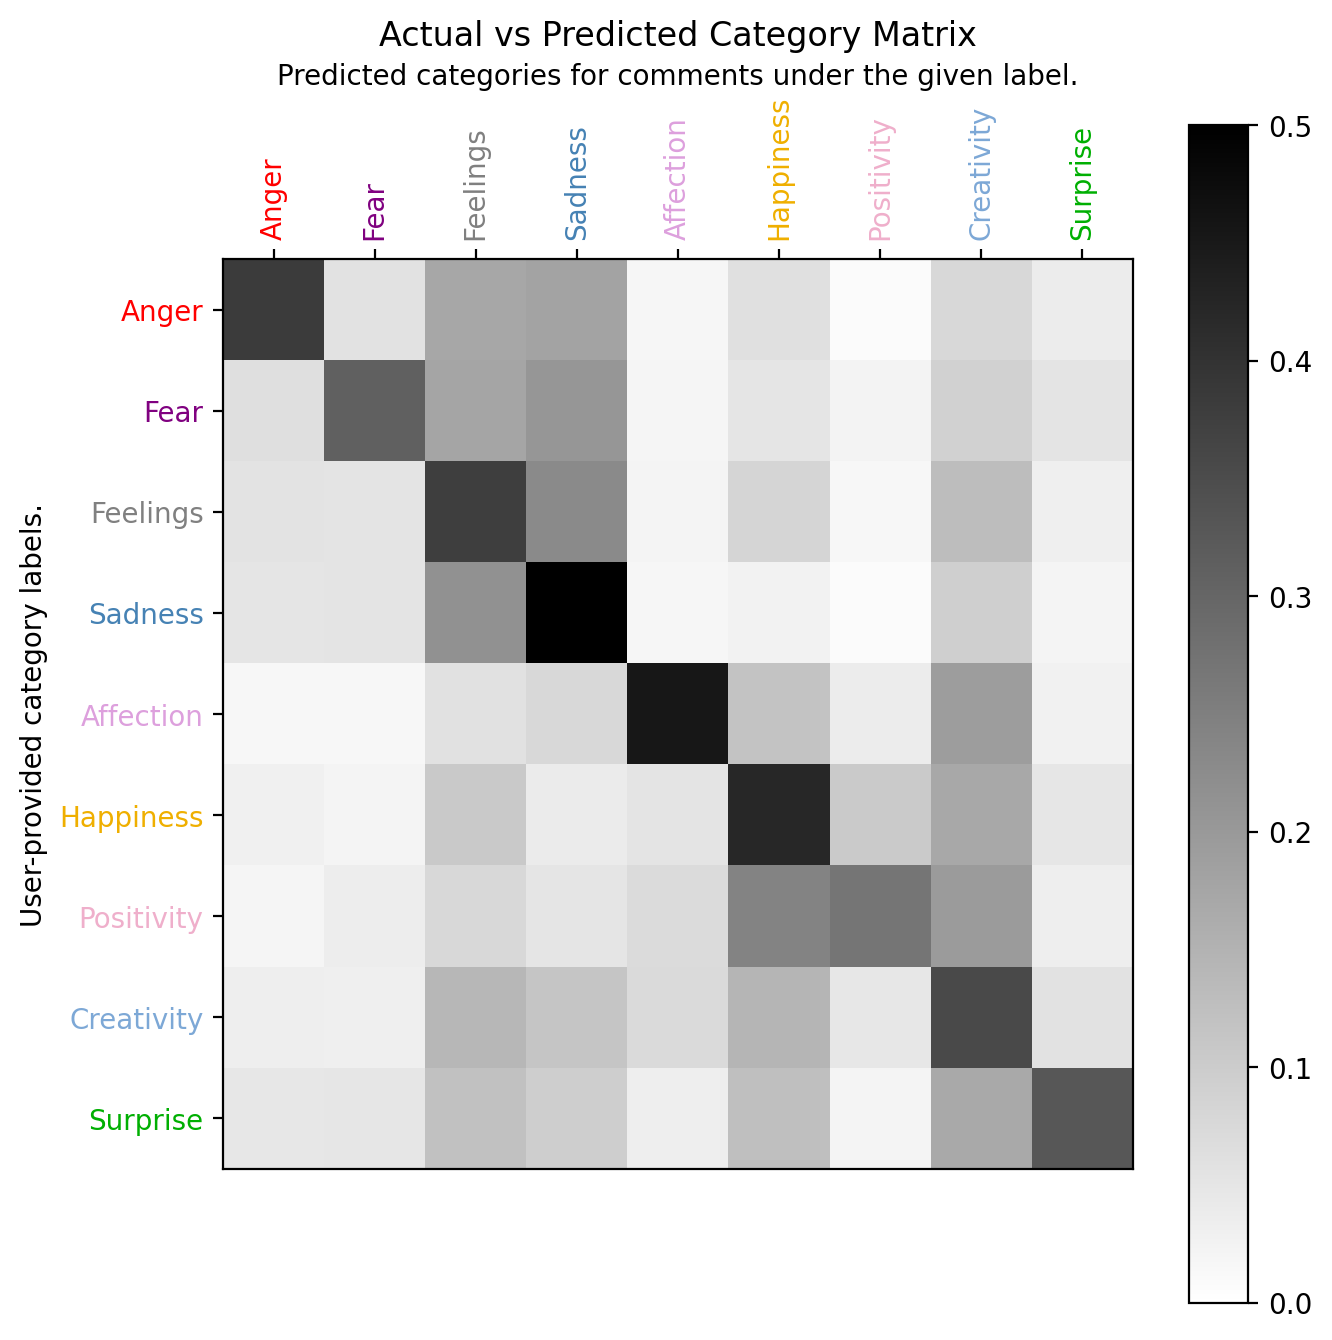

In [14]:
from matplotlib import pyplot as plt

dendrogram_cat_order = [label.get_text() for label in x_labels]
dendrogram_cat_indices = [category_index_mapping[label] for label in dendrogram_cat_order]

cat_confusion_matrix_dend = np.asarray([row[dendrogram_cat_indices] for row in cat_confusion_matrix])
cat_confusion_matrix_dend = cat_confusion_matrix_dend[dendrogram_cat_indices]

fig = plt.figure(figsize=(7, 7), dpi=200)
abs_max = round(cat_confusion_matrix_dend.max() * 20) / 20
plt.matshow(cat_confusion_matrix_dend, fignum=0, cmap='gist_yarg', vmin=0, vmax=abs_max)
plt.colorbar()
plt.title('Actual vs Predicted Category Matrix')
plt.xlabel('Predicted categories for comments under the given label.')
plt.ylabel('User-provided category labels.')
plt.yticks(np.arange(NUM_CATEGORIES), labels=dendrogram_cat_order)
plt.xticks(np.arange(NUM_CATEGORIES), labels=dendrogram_cat_order, rotation='vertical')
fig.axes[0].xaxis.tick_top()
fig.axes[0].xaxis.set_label_position('top')

for tick in list(fig.axes[0].xaxis.get_ticklabels()) + list(fig.axes[0].yaxis.get_ticklabels()):
    label = tick.get_text()
    color = category_colors[label]
    tick.set_color(color)

plt.tight_layout()
plt.savefig(f'../output/EmotionCategoryConfusionMatrixDendrogram{valid_suffix}.pdf')
plt.show()

# Label confusion table & predictions

Find the top 5 most chosen labels given every label and some sample predictions on the text.

In [15]:
for cat, th in sorted(zip(cats, thresholds), key=lambda x: -config['results']['test']['labels'][x[0]]['support']):
    if cat in labels_to_ignore:
        continue
    fields_string = ''
    for field, score in config['results']['test']['labels'][cat].items():
        fields_string = f'{fields_string} {field}: {score:.2f}'
    print(f'{cat} -- Threshold: {th:.2f}. {fields_string}')


Spacey -- Threshold: 0.06.  precision: 0.08 recall: 0.34 f1: 0.13 support: 39046.00
Meh -- Threshold: 0.08.  precision: 0.09 recall: 0.30 f1: 0.14 support: 38852.00
Amused -- Threshold: 0.15.  precision: 0.28 recall: 0.44 f1: 0.34 support: 38736.00
Tired -- Threshold: 0.14.  precision: 0.23 recall: 0.29 f1: 0.26 support: 36249.00
Sad -- Threshold: 0.10.  precision: 0.18 recall: 0.26 f1: 0.21 support: 29839.00
Miserable -- Threshold: 0.08.  precision: 0.14 recall: 0.31 f1: 0.20 support: 27409.00
Thoughtful -- Threshold: 0.07.  precision: 0.11 recall: 0.22 f1: 0.15 support: 27043.00
Needy -- Threshold: 0.21.  precision: 0.40 recall: 0.49 f1: 0.44 support: 24862.00
Lonely -- Threshold: 0.12.  precision: 0.27 recall: 0.37 f1: 0.31 support: 24340.00
Chill -- Threshold: 0.09.  precision: 0.12 recall: 0.22 f1: 0.15 support: 22992.00
Annoyed -- Threshold: 0.13.  precision: 0.22 recall: 0.30 f1: 0.25 support: 22819.00
Exhausted -- Threshold: 0.12.  precision: 0.17 recall: 0.22 f1: 0.19 support:

In [16]:
', '.join([valid_emos[x] for x in label_confusion_matrix.T.sum(axis=1).argsort()[::-1]])

print('\n'.join([f'{valid_emos[i]}: {", ".join([valid_emos[l] for l in labels])}' 
                 for i, labels in enumerate(label_confusion_matrix.argsort()[:,::-1][:, :5])]))

Adoring: Loving, Adoring, Infatuated, Affectionate, Spacey
Adventurous: Spacey, Chill, Adventurous, Needy, Dreamy
Affectionate: Affectionate, Loving, Needy, Infatuated, Spacey
Afraid: Afraid, Anxious, Miserable, Overwhelmed, Spacey
Amazed: Spacey, Amused, Amazed, Chill, Meh
Amused: Amused, Spacey, Meh, Chill, Annoyed
Angry: Frustrated, Bitter, Angry, Annoyed, Irritated
Annoyed: Annoyed, Irritated, Frustrated, Bitter, Meh
Anxious: Anxious, Overwhelmed, Nervous, Meh, Spacey
Artistic: Creative, Artistic, Spacey, Thoughtful, Chill
Ashamed: Ashamed, Miserable, Guilty, Numb, Empty
Astonished: Spacey, Amused, Surprised, Shocked, Confused
Awkward: Meh, Awkward, Spacey, Amused, Uncomfortable
Bitter: Bitter, Annoyed, Frustrated, Meh, Spacey
Bored: Bored, Meh, Spacey, Chill, Lonely
Calm: Chill, Spacey, Calm, Meh, Content
Caring: Supportive, Caring, Loving, Thoughtful, Spacey
Chill: Chill, Spacey, Meh, Amused, Content
Confident: Confident, Chill, Spacey, Optimistic, Thoughtful
Conflicted: Meh, Con

In [17]:
predictions = (', '.join([cats[idx] for idx in values[-5:][::-1]]) for values in output.argsort().tolist()[:100])

for i, p in zip(inputs, predictions):
    print(f'{p} -- {i}')

Confused, Awkward, Anxious, Spacey, Nervous -- Google how do I tell this 20 something dude that I’m not comfortable with him knowing my address? Thanks
Sick, Miserable, Uncomfortable, Anxious, Disgusted -- Every time I hear from you, I automatically feel sick. Go away please. 🙄
Chill, Calm, Meh, Spacey, Relaxed -- Sometimes I just be laying there watching the ceiling breathe It doesn't even freak me out anymore unless I'm paranoid beforehand. It's kinda cool.
Thoughtful, Meh, Spacey, Sad, Amused -- If you have a pet and you don’t treat it like your child, what’s the point? Fur babies deserve all the love.
Happy, Hungry, Chill, Content, Excited -- Dinner is now served😍😎🤠
Sad, Miserable, Exhausted, Upset, Overwhelmed -- research and research and research and research I hate crying because I don't feel better after crying Everything I do is hurting me I hope to expire
Curious, Amused, Interested, Needy, Imaginative -- Nsfw What is the weirdest thing you watched that turned you on? Mine ha